In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
path = os.path.join(os.getcwd(), os.pardir)
sys.path.append(path)

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm, skew
from sklearn import metrics
import matplotlib.pyplot as plt
import pylab as py
from BAI import environment, solver, analysis

In [3]:
plt.rcParams['figure.figsize'] = [10, 6]

# Two Batch Simulation

In [4]:
K = 3
n_parallels = 100000
n_batches = 2
batch_func = environment.func_constant_batch(1000)
reward_func = environment.func_gaussian_reward([0.0, 0.0, 0.0], [1, 1, 1])
bandit = environment.Bandit(K=K, reward_func=reward_func, batch_func=batch_func)

# NB-TS

In [5]:
G = 5000
tracking_history = []
for parallel_idx in range(n_parallels):
    SS_phi = [0 for i in range(K)]
    numerator = [0 for i in range(K)]
    denominator = [0 for i in range(K)]
    optimal_probs = [1 / K for i in range(K)]
    for batch_idx in range(n_batches):
        sampling_probs = [optimal_probs[i] / np.sum(optimal_probs) for i in range(K)]
        batch_feedback = bandit.batch_observe_fast(
            sampling_distrib = sampling_probs, 
            time_index=batch_idx
        )
        for arm_idx in range(K):
            batch_rewards = batch_feedback['rewards'][arm_idx]
            batch_trials = batch_feedback['trials'][arm_idx]
            phi = np.sqrt(batch_trials)
            SS_phi[arm_idx] += phi ** 2
            numerator[arm_idx] += phi * np.sqrt(batch_trials) * (batch_rewards / batch_trials)
            denominator[arm_idx] += phi * np.sqrt(batch_trials)
        mc_sampling = np.array([np.random.normal(numerator[i]/denominator[i], np.sqrt(1 * SS_phi[i]/denominator[i]**2), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # tracking history and analysis
        for arm_idx in range(K):
            tracking_reccord = (
                parallel_idx,
                batch_idx,
                arm_idx,
                sampling_probs[arm_idx],
                numerator[arm_idx]/denominator[arm_idx],
                denominator[arm_idx]**2 / SS_phi[arm_idx],
                optimal_probs[arm_idx],
                posterior_delta[arm_idx]
            )
            tracking_history.append(tracking_reccord)
# convert tracking_history to dataframe
df_NBTS = pd.DataFrame(tracking_history, columns=[
    'parallel_idx','batch_idx', 'arm_idx', 'sampling_prob', 
    'mu', 'tau', 'optimal_prob','posterior_delta'
])

In [6]:
df_NBTS.tail(3)

parallel_idx  batch_idx  arm_idx  sampling_prob        mu     tau  \
599997         99999          1        0         0.9130  0.057462  1280.0   
599998         99999          1        1         0.0132 -0.087265   342.0   
599999         99999          1        2         0.0738 -0.028321   378.0   

        optimal_prob  posterior_delta  
599997        0.9134         0.002301  
599998        0.0074         0.148012  
599999        0.0792         0.086723

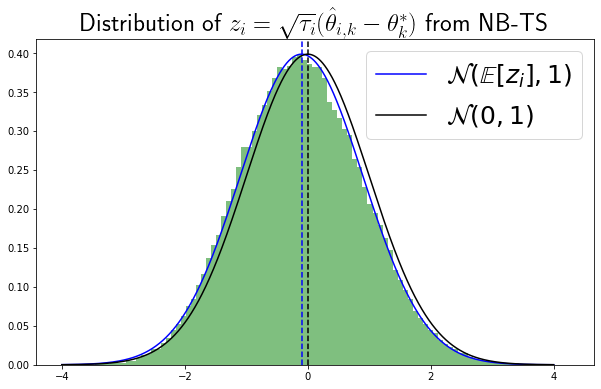

In [7]:
mus = df_NBTS.query("batch_idx == 1 and arm_idx == 0").mu
taus = df_NBTS.query("batch_idx == 1 and arm_idx == 0").tau
plt.hist(mus * np.sqrt(taus), 100, density=True, facecolor='green', alpha=0.5);
plt.plot(np.arange(-4, 4, 0.001), norm.pdf(np.arange(-4, 4, 0.001), (mus * np.sqrt(taus)).mean(), 1), color='blue');
plt.plot(np.arange(-4, 4, 0.001), norm.pdf(np.arange(-4, 4, 0.001), 0, 1), color='black');
plt.axvline(x=(mus * np.sqrt(taus)).mean(), linestyle='--', color='blue');
plt.axvline(x=0, linestyle='--', color='black');
plt.title(r'Distribution of $z_i = \sqrt{\tau_i} (\hat{\theta}_{i,k} - \theta^*_k)$ from NB-TS', fontsize=25, usetex = True)
plt.legend([r"$\mathcal{N}(\mathbb{E}[z_i],1)$", r"$\mathcal{N}(0,1)$"], loc ="upper right", fontsize=25);

# WB-TS

In [8]:
G = 5000
tracking_history = []
for parallel_idx in range(n_parallels):
    SS_phi = [0 for i in range(K)]
    numerator = [0 for i in range(K)]
    denominator = [0 for i in range(K)]
    optimal_probs = [1 / K for i in range(K)]
    for batch_idx in range(n_batches):
        sampling_probs = [optimal_probs[i] / np.sum(optimal_probs) for i in range(K)]
        batch_feedback = bandit.batch_observe_fast(
            sampling_distrib = sampling_probs, 
            time_index=batch_idx
        )
        batch_size = batch_feedback['batch_size']
        for arm_idx in range(K):
            batch_rewards = batch_feedback['rewards'][arm_idx]
            batch_trials = batch_feedback['trials'][arm_idx]
            phi = np.sqrt(batch_size)
            SS_phi[arm_idx] += phi ** 2
            numerator[arm_idx] += phi * np.sqrt(batch_trials) * (batch_rewards / batch_trials)
            denominator[arm_idx] += phi * np.sqrt(batch_trials)
        mc_sampling = np.array([np.random.normal(numerator[i]/denominator[i], np.sqrt(1 * SS_phi[i]/denominator[i]**2), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # tracking history and analysis
        for arm_idx in range(K):
            tracking_reccord = (
                parallel_idx,
                batch_idx,
                arm_idx,
                sampling_probs[arm_idx],
                numerator[arm_idx]/denominator[arm_idx],
                denominator[arm_idx]**2 / SS_phi[arm_idx],
                optimal_probs[arm_idx],
                posterior_delta[arm_idx]
            )
            tracking_history.append(tracking_reccord)
# convert tracking_history to dataframe
df_WBTS = pd.DataFrame(tracking_history, columns=[
    'parallel_idx','batch_idx', 'arm_idx', 'sampling_prob', 
    'mu', 'tau', 'optimal_prob', 'posterior_delta'
])

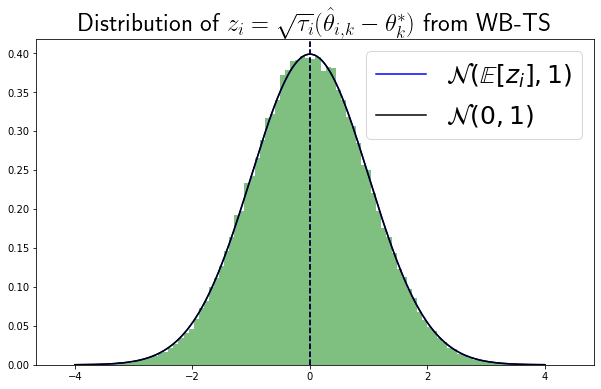

In [9]:
mus = df_WBTS.query("batch_idx == 1 and arm_idx == 0").mu
taus = df_WBTS.query("batch_idx == 1 and arm_idx == 0").tau
plt.hist(mus * np.sqrt(taus), 100, density=True, facecolor='green', alpha=0.5);
plt.plot(np.arange(-4, 4, 0.001), norm.pdf(np.arange(-4, 4, 0.001), (mus * np.sqrt(taus)).mean(), 1), color='blue');
plt.plot(np.arange(-4, 4, 0.001), norm.pdf(np.arange(-4, 4, 0.001), 0, 1), color='black');
plt.axvline(x=(mus * np.sqrt(taus)).mean(), linestyle='--', color='blue');
plt.axvline(x=0, linestyle='--', color='black');
plt.title(r'Distribution of $z_i = \sqrt{\tau_i} (\hat{\theta}_{i,k} - \theta^*_k)$ from WB-TS', fontsize=25, usetex = True)
plt.legend([r"$\mathcal{N}(\mathbb{E}[z_i],1)$", r"$\mathcal{N}(0,1)$"], loc ="upper right", fontsize=25);

# NB-TTTS

In [19]:
G = 5000
tracking_history = []
for parallel_idx in range(n_parallels):
    SS_phi = [0 for i in range(K)]
    numerator = [0 for i in range(K)]
    denominator = [0 for i in range(K)]
    optimal_probs = [1 / K for i in range(K)]
    for batch_idx in range(n_batches):
        optimal_odds = [optimal_probs[i] / (1 - optimal_probs[i]) if optimal_probs[i] < 1 else 99 for i in range(K)]
        sampling_probs = [optimal_probs[i] * 0.5 * (1 + np.sum(optimal_odds) - optimal_odds[i]) for i in range(K)]
        sampling_probs = [sampling_probs[i] / np.sum(sampling_probs) for i in range(K)]
        batch_feedback = bandit.batch_observe_fast(
            sampling_distrib = sampling_probs, 
            time_index=batch_idx
        )
        for arm_idx in range(K):
            batch_rewards = batch_feedback['rewards'][arm_idx]
            batch_trials = batch_feedback['trials'][arm_idx]
            phi = np.sqrt(batch_trials)
            SS_phi[arm_idx] += phi ** 2
            numerator[arm_idx] += phi * np.sqrt(batch_trials) * (batch_rewards / batch_trials)
            denominator[arm_idx] += phi * np.sqrt(batch_trials)
        mc_sampling = np.array([np.random.normal(numerator[i]/denominator[i], np.sqrt(1 * SS_phi[i]/denominator[i]**2), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # tracking history and analysis
        for arm_idx in range(K):
            tracking_reccord = (
                parallel_idx,
                batch_idx,
                arm_idx,
                sampling_probs[arm_idx],
                numerator[arm_idx]/denominator[arm_idx],
                denominator[arm_idx]**2 / SS_phi[arm_idx],
                optimal_probs[arm_idx]
            )
            tracking_history.append(tracking_reccord)
# convert tracking_history to dataframe
df_NBTTTS = pd.DataFrame(tracking_history, columns=[
    'parallel_idx','batch_idx', 'arm_idx', 'sampling_prob', 
    'mu', 'tau', 'optimal_prob'
])

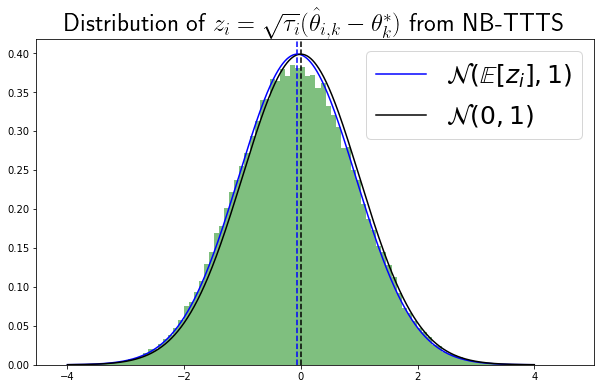

In [20]:
mus = df_NBTTTS.query("batch_idx == 1 and arm_idx == 0").mu
taus = df_NBTTTS.query("batch_idx == 1 and arm_idx == 0").tau
plt.hist(mus * np.sqrt(taus), 100, density=True, facecolor='green', alpha=0.5);
plt.plot(np.arange(-4, 4, 0.001), norm.pdf(np.arange(-4, 4, 0.001), (mus * np.sqrt(taus)).mean(), 1), color='blue');
plt.plot(np.arange(-4, 4, 0.001), norm.pdf(np.arange(-4, 4, 0.001), 0, 1), color='black');
plt.axvline(x=(mus * np.sqrt(taus)).mean(), linestyle='--', color='blue');
plt.axvline(x=0, linestyle='--', color='black');
plt.title(r'Distribution of $z_i = \sqrt{\tau_i} (\hat{\theta}_{i,k} - \theta^*_k)$ from NB-TTTS', fontsize=25, usetex = True)
plt.legend([r"$\mathcal{N}(\mathbb{E}[z_i],1)$", r"$\mathcal{N}(0,1)$"], loc ="upper right", fontsize=25);

# WB-TTTS

In [21]:
G = 5000
tracking_history = []
for parallel_idx in range(n_parallels):
    SS_phi = [0 for i in range(K)]
    numerator = [0 for i in range(K)]
    denominator = [0 for i in range(K)]
    optimal_probs = [1 / K for i in range(K)]
    for batch_idx in range(n_batches):
        optimal_odds = [optimal_probs[i] / (1 - optimal_probs[i]) if optimal_probs[i] < 1 else 99 for i in range(K)]
        sampling_probs = [optimal_probs[i] * 0.5 * (1 + np.sum(optimal_odds) - optimal_odds[i]) for i in range(K)]
        sampling_probs = [sampling_probs[i] / np.sum(sampling_probs) for i in range(K)]
        batch_feedback = bandit.batch_observe_fast(
            sampling_distrib = sampling_probs, 
            time_index=batch_idx
        )
        batch_size = batch_feedback['batch_size']
        for arm_idx in range(K):
            batch_rewards = batch_feedback['rewards'][arm_idx]
            batch_trials = batch_feedback['trials'][arm_idx]
            phi = np.sqrt(batch_size)
            SS_phi[arm_idx] += phi ** 2
            numerator[arm_idx] += phi * np.sqrt(batch_trials) * (batch_rewards / batch_trials)
            denominator[arm_idx] += phi * np.sqrt(batch_trials)
        mc_sampling = np.array([np.random.normal(numerator[i]/denominator[i], np.sqrt(1 * SS_phi[i]/denominator[i]**2), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # tracking history and analysis
        for arm_idx in range(K):
            tracking_reccord = (
                parallel_idx,
                batch_idx,
                arm_idx,
                sampling_probs[arm_idx],
                numerator[arm_idx]/denominator[arm_idx],
                denominator[arm_idx]**2 / SS_phi[arm_idx],
                optimal_probs[arm_idx],
                posterior_delta[arm_idx]
            )
            tracking_history.append(tracking_reccord)
# convert tracking_history to dataframe
df_WBTTTS = pd.DataFrame(tracking_history, columns=[
    'parallel_idx','batch_idx', 'arm_idx', 'sampling_prob', 
    'mu', 'tau', 'optimal_prob', 'posterior_delta'
])

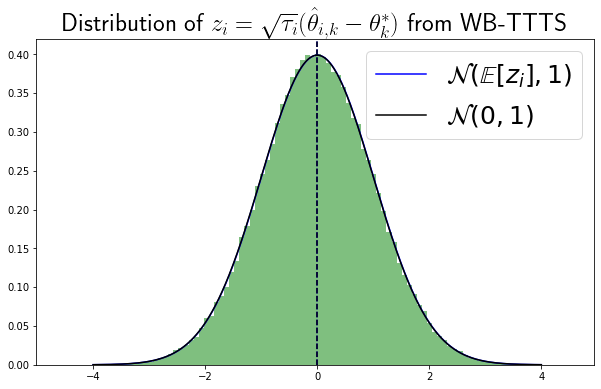

In [22]:
mus = df_WBTTTS.query("batch_idx == 1 and arm_idx == 0").mu
taus = df_WBTTTS.query("batch_idx == 1 and arm_idx == 0").tau
plt.hist(mus * np.sqrt(taus), 100, density=True, facecolor='green', alpha=0.5);
plt.plot(np.arange(-4, 4, 0.001), norm.pdf(np.arange(-4, 4, 0.001), (mus * np.sqrt(taus)).mean(), 1), color='blue');
plt.plot(np.arange(-4, 4, 0.001), norm.pdf(np.arange(-4, 4, 0.001), 0, 1), color='black');
plt.axvline(x=(mus * np.sqrt(taus)).mean(), linestyle='--', color='blue');
plt.axvline(x=0, linestyle='--', color='black');
plt.title(r'Distribution of $z_i = \sqrt{\tau_i} (\hat{\theta}_{i,k} - \theta^*_k)$ from WB-TTTS', fontsize=25, usetex = True)
plt.legend([r"$\mathcal{N}(\mathbb{E}[z_i],1)$", r"$\mathcal{N}(0,1)$"], loc ="upper right", fontsize=25);